In [1]:
import pandas as pd
import pymc as pm

df = pd.read_csv('~/data/Howell1c.csv')
# df = pd.read_csv('~/data/penguins/penguins_size.csv')
#df['adult'] = df['age'].apply(lambda x:1 if x>=20 else 0)

df = df.dropna()

target  = 'height'
predictors = ['weight','age','male']
predictors = ['age','male']

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import numpy as np
from pandas import DataFrame

gen_age = np.random.randint(10,70,size=1000)
b1 = 0.4
gen_adult = [0 if ag<20 else 1 if ag<50 else 2 for ag in gen_age]

height_sd = 2
def create_height(age,adult):
    n = np.random.randn(1)[0]
    if adult:
        return 20+height_sd*n
    return age+height_sd*n

gen_height = [create_height(age,adult) for age,adult in zip(gen_age,gen_adult)]

df = DataFrame({'age':gen_age,'adult':gen_adult,'height':gen_height})
df_adult = pd.get_dummies(df.adult, prefix='adult')

In [3]:
import pandas as pd

target = 'height' 
cat_feature_idx,cat_feature_codes = pd.factorize(df['adult'], sort=True)

In [4]:
cat_feature_codes

Int64Index([0, 1, 2], dtype='int64')

In [5]:
coords = {'adult':cat_feature_codes}


In [6]:
def standardize_vec(unstd_vec,mean,std):
    return (unstd_vec-mean)/std

df[target] = standardize_vec(df[target],df[target].mean(),df[target].std())
df['age'] = standardize_vec(df['age'],df['age'].mean(),df['age'].std())

In [7]:
df

,age,adult,height
0,-0.083635,1,-0.201968
1,0.035081,1,0.470777
2,0.035081,1,1.100723
3,-1.805016,0,-3.668425
4,0.213154,1,0.203561
...,...,...,...
995,-0.321067,1,0.094550
996,-1.508226,0,-2.798948
997,0.866092,2,1.140029
998,0.628660,2,0.068578


In [8]:
df_adult.values

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [18]:
import pymc as pm 
import pytensor.tensor as at


    # with pm.Model() as model:
    #     beta_g = pm.Normal("beta_g", mu=0, sigma=1)
    #     gamma = pm.Gamma("gamma", alpha=10, beta=10)
    #     z = pm.Normal("z", mu=0, sigma=1, shape=X.shape[1])
    #     sigma = pm.Gamma("sigma", alpha=3, beta=3)
    #     beta = beta_g + gamma * z
    #     y = pm.Normal(
    #         "y",
    #         mu=at.dot(X, beta),
    #         sigma=sigma,
    #         shape=X.shape[:-1],
    #         observed=y
    #     )
    # return model



with pm.Model(coords=coords) as model:

    age_d = pm.MutableData(f'age_d',df[['age']])
    # adult_d = pm.MutableData('adult_d',df_adult.values)
    adult_d = pm.MutableData('adult_d',df['adult'].values)

    # thersh = pm.Normal(f'thersh', mu=50, sigma=10,dims='adult')

    # alfa = pm.Normal('alfa', mu=0, sigma=1, shape=(1,len(cat_feature_codes)))#dims='adult'
    beta = pm.Normal('beta', mu=0, sigma=1, shape=(1,len(cat_feature_codes)))
    # mu = at.dot(age_d,beta)+alfa
    # mu = beta*age_d+alfa
    mu = pm.Deterministic('mu', at.dot(age_d,beta))
    # print(alfa.shape)
    # print(beta.shape)
    # print(age_d.shape)
    # print(df[['age']].shape)
    # print(mu.shape)

    p = pm.Deterministic('p',pm.math.softmax(mu,axis=1))
    # p = pm.math.softmax(mu,axis=1)#scipy.special.softmax(mu)

    # adult = pm.Multinomial('adult',n=1,p=p, shape=mu.shape,observed=adult_d)
    adult = pm.Categorical('adult',p=p, observed=adult_d)
    # adult = pm.Categorical('adult',p=p, observed=None)
    print(f'adult {adult.shape} {df_adult.values.shape}')

    # a_global = pm.Normal(f'aglob', mu=0, sigma=1)
    # acn = pm.Normal(f'acn', mu=a_global, sigma=1, dims='adult')

    # b_global = pm.Normal(f'bglob', mu=0, sigma=1)
    # bcn = pm.Normal(f'bcn', mu=b_global, sigma=1, dims='adult')

    # sigma = pm.Uniform("sigma", 0, 20)
    
    # mu = pm.Deterministic(f'mu_{target}', acn[adult]+bcn[adult]*age_d)
    
    # target_var = pm.Normal(target, mu=mu, sigma=sigma, observed=df[target],shape=mu.shape)
    prior = pm.sample_prior_predictive(samples=1)
    idata = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)


ValueError: Softmax axis(=1) out of bounds for 1D array mu

In [16]:
with pm.Model(coords=coords) as model:
    xx = sum([pm.Normal('guyguy', mu=0, sigma=1,shape=1)*df[p] for p in ['age']])

    print(xx)

Elemwise{add,no_inplace}.0


In [128]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-1.379,0.585,-2.422,-0.272,0.036,0.027,259.0,367.0,1.01
"beta[0, 1]",-0.934,0.586,-2.002,0.159,0.036,0.027,263.0,351.0,1.01
"beta[0, 2]",2.224,0.592,1.178,3.319,0.035,0.024,293.0,423.0,1.01
"mu[0, 0]",-1.985,0.842,-3.487,-0.392,0.052,0.038,259.0,367.0,1.01
"mu[0, 1]",-1.344,0.844,-2.882,0.229,0.052,0.039,263.0,351.0,1.01
...,...,...,...,...,...,...,...,...,...
"p[998, 1]",0.407,0.013,0.381,0.430,0.000,0.000,1974.0,1437.0,1.00
"p[998, 2]",0.060,0.007,0.049,0.073,0.000,0.000,1519.0,1215.0,1.00
"p[999, 0]",0.023,0.004,0.014,0.030,0.000,0.000,1510.0,1335.0,1.00
"p[999, 1]",0.036,0.007,0.024,0.049,0.000,0.000,1557.0,1200.0,1.00


In [130]:
prior.prior.mu.values[0][0][0:7]

array([[-0.62421917, -0.15682368,  0.61939355],
       [ 0.51050052,  0.12825394, -0.50655402],
       [-0.59955135, -0.15062634,  0.59491643],
       [ 0.18981887,  0.04768853, -0.18835145],
       [ 0.53516834,  0.13445128, -0.53103114],
       [ 0.38716142,  0.09726725, -0.38416842],
       [ 0.58450398,  0.14684596, -0.57998539]])

In [135]:
from enum import Enum
(prior.prior.mu.values[0][0][0:7],axis=1)

array([[0.16490894, 0.26316703, 0.57192403],
       [0.48924028, 0.33382175, 0.17693797],
       [0.17040341, 0.26695861, 0.56263798],
       [0.39175405, 0.33984984, 0.26839611],
       [0.49648632, 0.33256618, 0.17094749],
       [0.45233712, 0.33850321, 0.20915967],
       [0.51082215, 0.32975946, 0.15941839]])

In [120]:

scipy.special.softmax(prior.prior.mu.values[0][0][0:10],axis=1),prior.prior.mu.values[0][0][0:10]

(array([[0.03495014, 0.34811508, 0.61693478],
        [0.80116158, 0.12226698, 0.07657144],
        [0.03867854, 0.35179876, 0.6095227 ],
        [0.52225084, 0.25960553, 0.21814364],
        [0.81653624, 0.11379282, 0.06967094],
        [0.70978121, 0.17059328, 0.11962551],
        [0.84444254, 0.09813189, 0.05742557],
        [0.30437452, 0.34268107, 0.35294441],
        [0.72995949, 0.16020885, 0.10983166],
        [0.03867854, 0.35179876, 0.6095227 ]]),
 array([[-2.51726118, -0.21865056,  0.35357966],
        [ 2.058673  ,  0.17881736, -0.28916543],
        [-2.41778435, -0.21000995,  0.33960694],
        [ 0.76547421,  0.06648947, -0.10752008],
        [ 2.15814983,  0.18745797, -0.30313815],
        [ 1.56128885,  0.13561432, -0.21930183],
        [ 2.35710349,  0.20473918, -0.33108359],
        [-0.12981726, -0.01127599,  0.0182344 ],
        [ 1.66076568,  0.14425493, -0.23327455],
        [-2.41778435, -0.21000995,  0.33960694]]))

In [125]:
prior.prior

<xarray.Dataset>
Dimensions:      (chain: 1, draw: 1, mu_dim_0: 1000, mu_dim_1: 3,
                  beta_dim_0: 1, beta_dim_1: 3, adult_dim_0: 1000,
                  p_dim_0: 1000, p_dim_1: 3)
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0
  * mu_dim_0     (mu_dim_0) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mu_dim_1     (mu_dim_1) int64 0 1 2
  * beta_dim_0   (beta_dim_0) int64 0
  * beta_dim_1   (beta_dim_1) int64 0 1 2
  * adult_dim_0  (adult_dim_0) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * p_dim_0      (p_dim_0) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * p_dim_1      (p_dim_1) int64 0 1 2
Data variables:
    mu           (chain, draw, mu_dim_0, mu_dim_1) float64 0.948 ... -0.4163
    beta         (chain, draw, beta_dim_0, beta_dim_1) float64 0.6584 ... -0....
    adult        (chain, draw, adult_dim_0) int64 0 0 0 2 2 0 1 ... 1 1 2 1 2 1
    p            (chain, draw, p_dim_0, p_dim_1) float64 0.1971 ... 0.08333
Attributes:
    created_at:                 2023-03-17T15:24:56.054209
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.2

In [91]:
y = az.extract(prior,'prior')['adult'][:,0]
true_parameters = prior
print(true_parameters)

    # idata = pm.sample(1000, tune=1000)
    # pm.sample_posterior_predictive(idata, extend_inferencedata=True)

KeyError: 'adult'

In [87]:
df[['age']].dropna()

,age
0,1.439913
1,-1.177593
2,1.383010
3,-0.437863
4,-1.234495
...,...
995,0.870890
996,-1.405202
997,0.358769
998,-0.608570


In [81]:
mu= 1.439913*np.array([[ 0.88585904,  0.33717908, -10.65018181]])

pm.math.softmax(mu,axis=None)

Softmax{axis=None}.0

In [82]:
mu

array([[  1.27555995,   0.48550854, -15.33533524]])

In [86]:
import scipy
scipy.special.softmax([-3.02,-3.02], axis=None)

array([0.5, 0.5])

In [45]:
import statsmodels.api as sm
from scipy.special import softmax
n = 100
betas = [0, 2, 0]

x1 = np.random.rand(n*(len(betas)-1)) * 5 -2.5
x1 = x1.reshape(n, (len(betas)-1))
x1 = sm.add_constant(x1)
mu1 = np.dot(x1, betas)

x2 = np.random.rand(n*(len(betas)-1)) * 5 -2.5
x2 = x2.reshape(n, (len(betas)-1))
x2 = sm.add_constant(x2)
mu2 = np.dot(x2, betas)

softprobs = [softmax([t1, t2]) for t1, t2 in zip(mu1, mu2)]
y = [np.random.choice((0,1), p=p) for p in softprobs]

y_mn = np.array([[0,1] if t == 0 else [1,0] for t in y])


In [64]:
len(softprobs)

100

In [67]:
x1[0]

array([1.        , 2.4372998 , 2.01045978])

In [69]:
def model_factory(X=np.arange(3), y=None):
    with pm.Model() as model:
        beta_g = pm.Normal("beta_g", mu=0, sigma=1)
        gamma = pm.Gamma("gamma", alpha=10, beta=10)
        z = pm.Normal("z", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.Gamma("sigma", alpha=3, beta=3)
        beta = beta_g + gamma * z
        y = pm.Normal(
            "y",
            mu=at.dot(X, beta),
            sigma=sigma,
            shape=X.shape[:-1],
            observed=y
        )
    return model

# Data generation
X = np.random.randn(400, 3)
X[:, 0] = 1.
with model_factory(X):
    prior = pm.sample_prior_predictive(samples=1)
y = az.extract(prior,'prior')['y'][:,0]
true_parameters = prior
print(true_parameters)

# Inference
with model_factory(X, y) as model:
    trace = pm.sample()
    pm.plot_posterior(trace)

4.874599590007186

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 38 seconds.


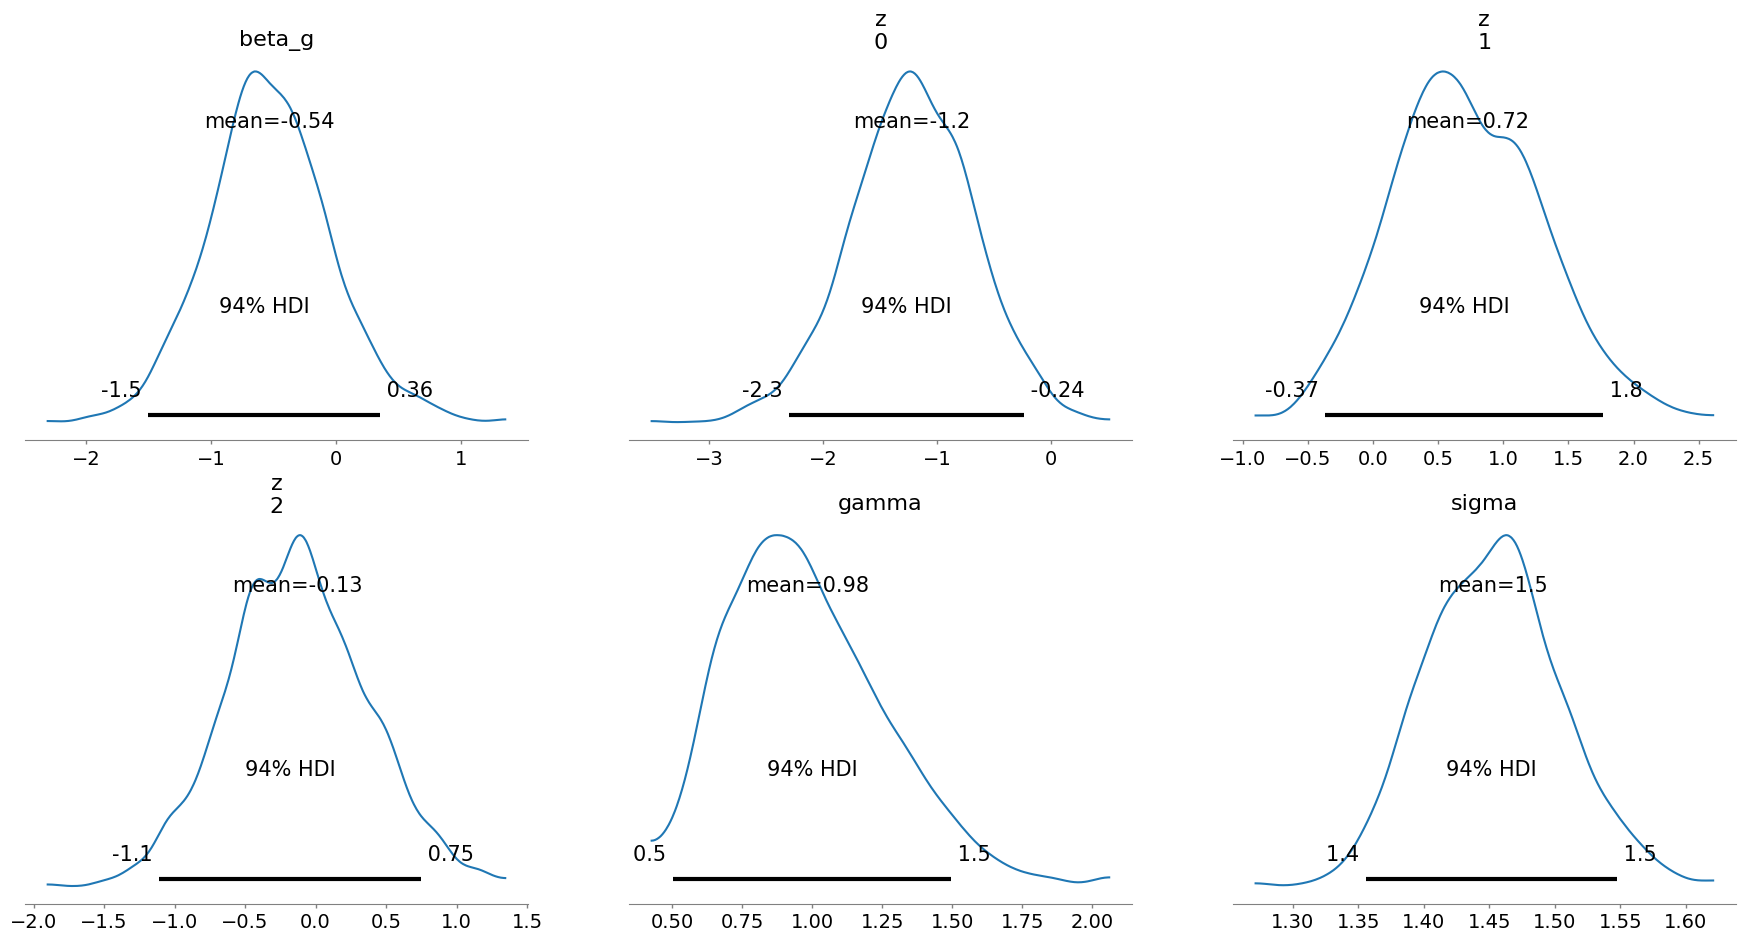

In [46]:

# Model definition is encapsulated to easily use with or without observations
def model_factory(X=np.arange(3), y=None):
    with pm.Model() as model:
        beta_g = pm.Normal("beta_g", mu=0, sigma=1)
        gamma = pm.Gamma("gamma", alpha=10, beta=10)
        z = pm.Normal("z", mu=0, sigma=1, shape=X.shape[1])
        sigma = pm.Gamma("sigma", alpha=3, beta=3)
        beta = beta_g + gamma * z
        y = pm.Normal(
            "y",
            mu=at.dot(X, beta),
            sigma=sigma,
            shape=X.shape[:-1],
            observed=y
        )
    return model

# Data generation
X = np.random.randn(400, 3)
X[:, 0] = 1.
with model_factory(X):
    prior = pm.sample_prior_predictive(samples=1)
y = az.extract(prior,'prior')['y'][:,0]
true_parameters = prior
print(true_parameters)

# Inference
with model_factory(X, y) as model:
    trace = pm.sample()
    pm.plot_posterior(trace)

In [47]:
X.shape[:-1]

(400,)

In [45]:
import arviz as az
az.extract(prior,'prior')['y'][:,0]


<xarray.DataArray 'y' (y_dim_0: 400)>
array([-3.62721959, -3.58908529, -1.4951212 , -3.28157903, -2.38892997,
       -5.17026793, -3.47410863, -8.08379852, -5.24645305, -2.23764644,
       -0.29802262, -2.81347382, -3.98146478, -5.21160179, -1.84557998,
       -3.10075945, -3.2998682 , -3.36079801, -4.61418874, -4.45201059,
       -4.16908792, -4.24372818, -2.03906659, -4.62289862, -4.90073599,
       -5.20144402, -4.2246941 , -2.28450079, -2.4674484 , -6.33503466,
       -3.88884883, -4.93758543, -4.85575723,  1.1198828 , -3.11424408,
       -2.62837234, -3.73136146, -4.19962879, -3.16439934, -6.34250158,
       -4.94674522, -1.05216762,  0.4891746 , -5.44398763, -0.71343688,
       -3.39573506, -3.12372139, -3.92941549, -2.80425991, -2.90156545,
       -5.37948271, -2.78237658, -3.3196001 , -5.86011785, -1.4618792 ,
       -2.42019659, -3.09172255, -3.98960399, -3.03819857, -3.59862572,
       -3.68739827, -3.27282869,  0.06305186, -1.63865529, -1.64238211,
       -5.16316298, -3.36917174, -3.10911156, -3.6768921 , -5.50011097,
       -3.01633468, -1.70528868, -1.34233733, -3.58932433, -3.27782629,
       -2.13509263, -4.69830685, -3.97510531, -6.41969491, -5.51871846,
       -3.61938499, -0.24405984, -3.65940515, -2.62014726, -0.35159157,
       -1.64560289, -4.79250585, -4.74965392, -2.83763779, -6.88945767,
       -3.77612165, -5.07910719, -3.77992427, -2.21116589, -3.83184597,
       -2.43543279, -1.5918348 , -1.2713922 , -3.08064254, -2.95891721,
...
       -3.16092388, -3.17153372, -5.69534132, -0.85123074, -3.09255241,
       -5.31153679, -1.94701462, -2.32898456, -4.93958437, -1.77984786,
       -3.79437217, -3.08318301, -4.52825385, -4.19052735, -3.16324509,
       -4.78214186, -3.19027056,  1.20991522, -3.39185345, -4.45714419,
       -6.06181208, -3.76291586, -4.86850924, -4.58694069, -3.03296324,
       -5.41145714, -5.67397669, -2.37545621, -3.71465254, -2.36152153,
       -2.58969383, -2.76532812, -4.0812055 , -0.79150802,  0.11793097,
       -3.55314071, -1.87767916, -7.88740977, -3.53897221, -3.41625673,
       -5.56407166, -3.8130408 , -3.61292466, -2.26683895, -3.67856082,
       -4.16102891, -3.19740098, -7.56861189, -4.64878598, -1.23082716,
       -5.70220468, -5.33863571, -3.80418597, -4.79046004, -1.93544588,
       -2.39724438, -4.24943702, -6.78548272, -3.36725205, -3.90030702,
       -2.8748897 , -5.22246177, -0.43382234, -4.44090864, -1.42685368,
       -3.4536799 , -2.33553753, -3.11252202, -3.85673525, -4.98015178,
       -4.16379169, -4.89628151, -4.06643766, -2.70015933, -5.45258886,
       -3.20658662, -3.75092552,  0.76806754, -4.83481448, -2.92657724,
       -3.45545325, -3.44419674, -4.16577357, -5.03281099, -3.63112438,
       -1.82773633, -2.83443436,  0.04431466, -5.52092961, -3.70029542,
       -4.04918764, -3.16001512, -3.63090318, -1.67467927, -5.04240324,
       -6.20633069, -2.29165025, -2.11282801, -3.71167889, -1.41898062])
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
    sample   object (0, 0)
    chain    int64 0
    draw     int64 0

In [104]:
with pm.Model(coords=coords) as model:

    age_d = pm.MutableData(f'age_d',df['age'])
    adult_d = pm.MutableData('adult_d',cat_feature_idx)
    thersh = pm.Normal(f'thersh', mu=50, sigma=10)

    likelihood = pm.invlogit(age_d-thersh)
    adult = pm.Bernoulli('adult',likelihood,shape=likelihood.shape,observed=adult_d)

    a_global = pm.Normal(f'aglob', mu=0, sigma=1)
    acn = pm.Normal(f'acn', mu=a_global, sigma=1, dims='adult')

    b_global = pm.Normal(f'bglob', mu=0, sigma=1)
    bcn = pm.Normal(f'bcn', mu=b_global, sigma=1, dims='adult')

    sigma = pm.Uniform("sigma", 0, 20)
    
    mu = pm.Deterministic(f'mu_{target}', acn[adult]+bcn[adult]*age_d)
    
    target_var = pm.Normal(target, mu=mu, sigma=sigma, observed=df[target],shape=mu.shape)

    idata = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)


In [106]:
fig = pm.model_to_graphviz(model)


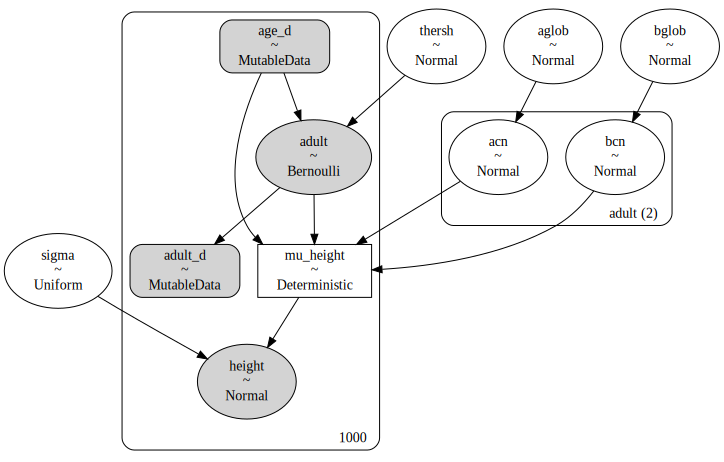

In [107]:
fig

In [97]:
az.summary(idata).head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
thersh,19.470,0.326,18.851,20.076,0.006,0.004,2871.0,1098.0,1.00
aglob,7.835,0.671,6.550,9.079,0.017,0.012,1571.0,1108.0,1.00
acn[0],5.427,0.935,3.651,7.127,0.027,0.019,1205.0,1059.0,1.00
acn[1],18.035,0.304,17.473,18.635,0.009,0.006,1179.0,1089.0,1.00
bglob,0.249,0.591,-0.885,1.309,0.011,0.015,2990.0,1230.0,1.01
bcn[0],0.678,0.062,0.561,0.788,0.002,0.001,1262.0,1227.0,1.00
bcn[1],0.045,0.007,0.033,0.058,0.000,0.000,1136.0,1054.0,1.00
sigma,2.120,0.071,1.996,2.253,0.002,0.001,1773.0,1271.0,1.00
mu_height[0],19.556,0.120,19.336,19.783,0.003,0.002,1594.0,1328.0,1.00
mu_height[1],18.974,0.180,18.665,19.340,0.005,0.004,1301.0,1374.0,1.00


In [98]:
df_counterfactual = DataFrame({'age':[5,10,11,19,20,23,24,25,50,100]})

with model:
    pm.set_data({'age_d': df_counterfactual['age'].values})
    # pm.set_data({'adult_d': df_counterfactual['adult'].values})

    # use the updated values and predict outcomes and probabilities:
    # thinned_idata = idata.sel(draw=slice(None, None, 5))

    idata_2 = pm.sample_posterior_predictive(
        idata,
        var_names=[target,f'mu_{target}'],
        return_inferencedata=True,
        predictions=True,
    )

In [99]:
az.summary(idata_2)

/home/guyyos/miniconda3/envs/tusha-env/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: predictions
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height[0],8.785,2.238,4.167,12.796,0.057,0.041,1513.0,1963.0,1.0
height[1],12.177,2.162,8.062,16.070,0.054,0.038,1600.0,1827.0,1.0
height[2],12.931,2.135,9.103,17.087,0.050,0.035,1862.0,1940.0,1.0
height[3],18.538,2.152,14.412,22.387,0.049,0.035,1878.0,1822.0,1.0
height[4],18.883,2.113,14.896,22.825,0.047,0.033,2009.0,1959.0,1.0
height[5],19.097,2.187,14.968,23.154,0.048,0.034,2096.0,2004.0,1.0
height[6],19.108,2.163,15.211,23.314,0.049,0.035,1924.0,1870.0,1.0
height[7],19.102,2.179,15.079,23.055,0.047,0.033,2150.0,2144.0,1.0
height[8],20.262,2.136,16.442,24.491,0.047,0.033,2086.0,2006.0,1.0
height[9],22.479,2.142,18.491,26.309,0.047,0.033,2082.0,1992.0,1.0


In [76]:
with pm.Model() as model:
    age_d = pm.MutableData(f'age_d',df['age'])
    adult_d = pm.MutableData(f'adult_d',df['adult'])

    sigma = pm.Uniform("sigma", 0, 20)
    
    b1 = pm.Normal(f'b1', mu=0, sigma=1)

    likelihood = pm.invlogit(age_d-20)

    # Bernoulli random vector with probability of success
    # given by sigmoid function and actual data as observed
    adult = pm.Bernoulli('adult',likelihood,shape=likelihood.shape,observed=adult_d)
    b21 = pm.Normal(f'b21', mu=0, sigma=5)
    b22 = pm.Normal(f'b22', mu=0, sigma=5)

    mu = pm.Deterministic(f'mu_{target}', b21*adult+b22)

    target_var = pm.Normal(target, mu=mu, sigma=sigma, shape=mu.shape, observed=df[target])

    idata = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)


In [77]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,0.045,1.032,-1.890,1.947,0.026,0.024,1579.0,1174.0,1.0
b21,5.950,0.616,4.872,7.199,0.020,0.014,956.0,1204.0,1.0
b22,13.897,0.566,12.774,14.911,0.018,0.013,953.0,1092.0,1.0
sigma,2.248,0.162,1.932,2.536,0.004,0.003,1490.0,1064.0,1.0
mu_height[0],13.897,0.566,12.774,14.911,0.018,0.013,953.0,1092.0,1.0
...,...,...,...,...,...,...,...,...,...
mu_height[95],19.847,0.239,19.392,20.272,0.005,0.004,2053.0,1610.0,1.0
mu_height[96],19.847,0.239,19.392,20.272,0.005,0.004,2053.0,1610.0,1.0
mu_height[97],19.847,0.239,19.392,20.272,0.005,0.004,2053.0,1610.0,1.0
mu_height[98],19.847,0.239,19.392,20.272,0.005,0.004,2053.0,1610.0,1.0


In [78]:
from pandas import DataFrame

df_counterfactual = DataFrame({'age':[19,20,23,24,25,50,100]})

with model:
    pm.set_data({'age_d': df_counterfactual['age'].values})
    # pm.set_data({'adult_d': df_counterfactual['adult'].values})

    # use the updated values and predict outcomes and probabilities:
    # thinned_idata = idata.sel(draw=slice(None, None, 5))

    idata_2 = pm.sample_posterior_predictive(
        idata,
        var_names=[target,f'mu_{target}'],
        return_inferencedata=True,
        predictions=True,
    )

In [79]:
import arviz as az 

az.summary(idata_2)

/home/guyyos/miniconda3/envs/tusha-env/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: predictions
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height[0],15.591,3.512,9.541,22.214,0.080,0.057,1909.0,1794.0,1.0
height[1],16.778,3.815,9.660,23.002,0.087,0.062,1903.0,1874.0,1.0
height[2],19.617,2.487,14.918,24.258,0.057,0.040,1879.0,1921.0,1.0
height[3],19.874,2.342,15.609,24.213,0.051,0.036,2105.0,1927.0,1.0
height[4],19.777,2.289,15.689,24.308,0.054,0.038,1772.0,1633.0,1.0
height[5],19.884,2.223,15.403,23.764,0.049,0.035,2022.0,1924.0,1.0
height[6],19.803,2.262,15.567,23.839,0.051,0.036,1951.0,1820.0,1.0
mu_height[0],15.548,2.713,12.976,20.206,0.061,0.043,1589.0,1313.0,1.0
mu_height[1],16.864,3.011,13.045,20.195,0.069,0.049,1865.0,1444.0,1.0
mu_height[2],19.614,1.182,19.255,20.378,0.027,0.019,2125.0,1610.0,1.0


In [29]:
import arviz as az 

az.summary(idata_2)

/home/guyyos/miniconda3/envs/tusha-env/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: predictions
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height[0],34.686,21.441,-5.018,74.019,0.504,0.357,1798.0,1724.0,1.0
height[1],52.473,21.600,13.757,92.267,0.486,0.344,1978.0,1968.0,1.0
height[2],68.251,21.199,29.864,108.014,0.489,0.346,1881.0,1751.0,1.0
mu_height[0],34.314,7.251,20.201,47.424,0.161,0.114,2021.0,1774.0,1.0
mu_height[1],51.774,7.365,38.186,65.664,0.163,0.116,2022.0,1859.0,1.0
mu_height[2],68.688,7.437,54.810,82.050,0.161,0.114,2144.0,1781.0,1.0
